# Benchmarking improvements in  Numba 0.52.0rc1

With Numba 0.52.0rc1 two important improvements were added to Numba that significantly improve performance across a number of use-cases:

* Improvements to the typed-list implementation (Stuart)
* A reference-operation (refop) pruning pass using the LLVM API and implemented in C++ (Siu)

In this notebook, we present an analysis of the benchmarks for these improvements using the Airspeed Velocity (ASV) tool. The source code for generating these benchmarks can be found at:

https://github.com/numba/numba-benchmark/pull/10

In [1]:
# imports and utilities
import json
import pandas
import hvplot.pandas
import re
from IPython.display import Image


def extract_results(filename, commit_id):
    # load data
    with open(filename) as fp:
        data = json.load(fp)  
    index = [k for k in data['results'].keys() if isinstance(data['results'][k], dict)]
    columns = [commit_id]
    pdata = [data['results'][i]['result'] for i in index if isinstance(data['results'][i], dict)]
    pindex = [i[17:] for i in index]
    df = pandas.DataFrame(pdata, index=pindex, columns=columns)
    return df


def plot02(dataframe, height=500, width=1000, **kwargs):
    return dataframe.hvplot.barh(height=height,width=width, **kwargs).opts(hooks=[rotate_group_labels])

def plot01(dataframe):
    return dataframe.plot.barh(color={"master": "red", "v0.51.2": "green"})

def rotate_group_labels(plot, element):
    plot.state.yaxis.group_label_orientation = 0
    plot.state.xaxis.axis_label = 'Time (s)'

In [2]:
# loading benchmark data
df1 = extract_results("3a682bd8-conda-py3.6-cudatoolkit-llvmlite-numpy.json", 'v0.52.0rc1')
df2 = extract_results("9d570961-conda-py3.6-cudatoolkit-llvmlite-numpy.json", 'v0.51.2')
df3 = extract_results("ac19226d-conda-py3.6-cudatoolkit-llvmlite-numpy.json", 'pr/6369')
dfc1 = pandas.concat((df1, df2))
dfc2 = pandas.concat((df3, df1))

# What did we benchmark?

We benchmarked a number of "Suites", each one corresponding to a different kind of use-case, when iterating over a typed-list

* `ForLoopReductionSuite`
```python
        def reduction_sum(tl):
            agg = 0
            length = len(tl)
            for i in range(length):
                agg += tl[i]
            return agg
```

* `GetitemUncheckedReductionSuite`
```python
        def reduction_sum(tl)
            agg = 0
            length = len(tl)
            for i in range(length):
                agg += tl.getitem_unchecked(i)
            return agg
```

* `IteratorReductionSuite`
```python
        def reduction_sum(tl):
            agg = 0
            for i in tl:
                agg += i
            return agg
```

For these, we benchmark the combination of `{compile/execute,fastmath/no_fastmath,int/float}`.


We then also have some ancillary use-cases, for which we benchmarked limited combinations.

* `ArrayListSuite`
```python
        @njit
        def make_random_typed_list_array(n):
            tl = List()
            for i in range(n):
                tl.append(np.zeros(4,))
            return tl

        def array_reduction(tl):
            agg = 0.0
            for i in tl:
                agg += i.sum()
            return agg
```

* `SortSuite`
* `ConstructionSuite`

Note: this is all dones using Python 3.6 and the system compilers on OSX. This is due to an unresolved bug in the ASV tool.

# Screenshot of  `asv compare`

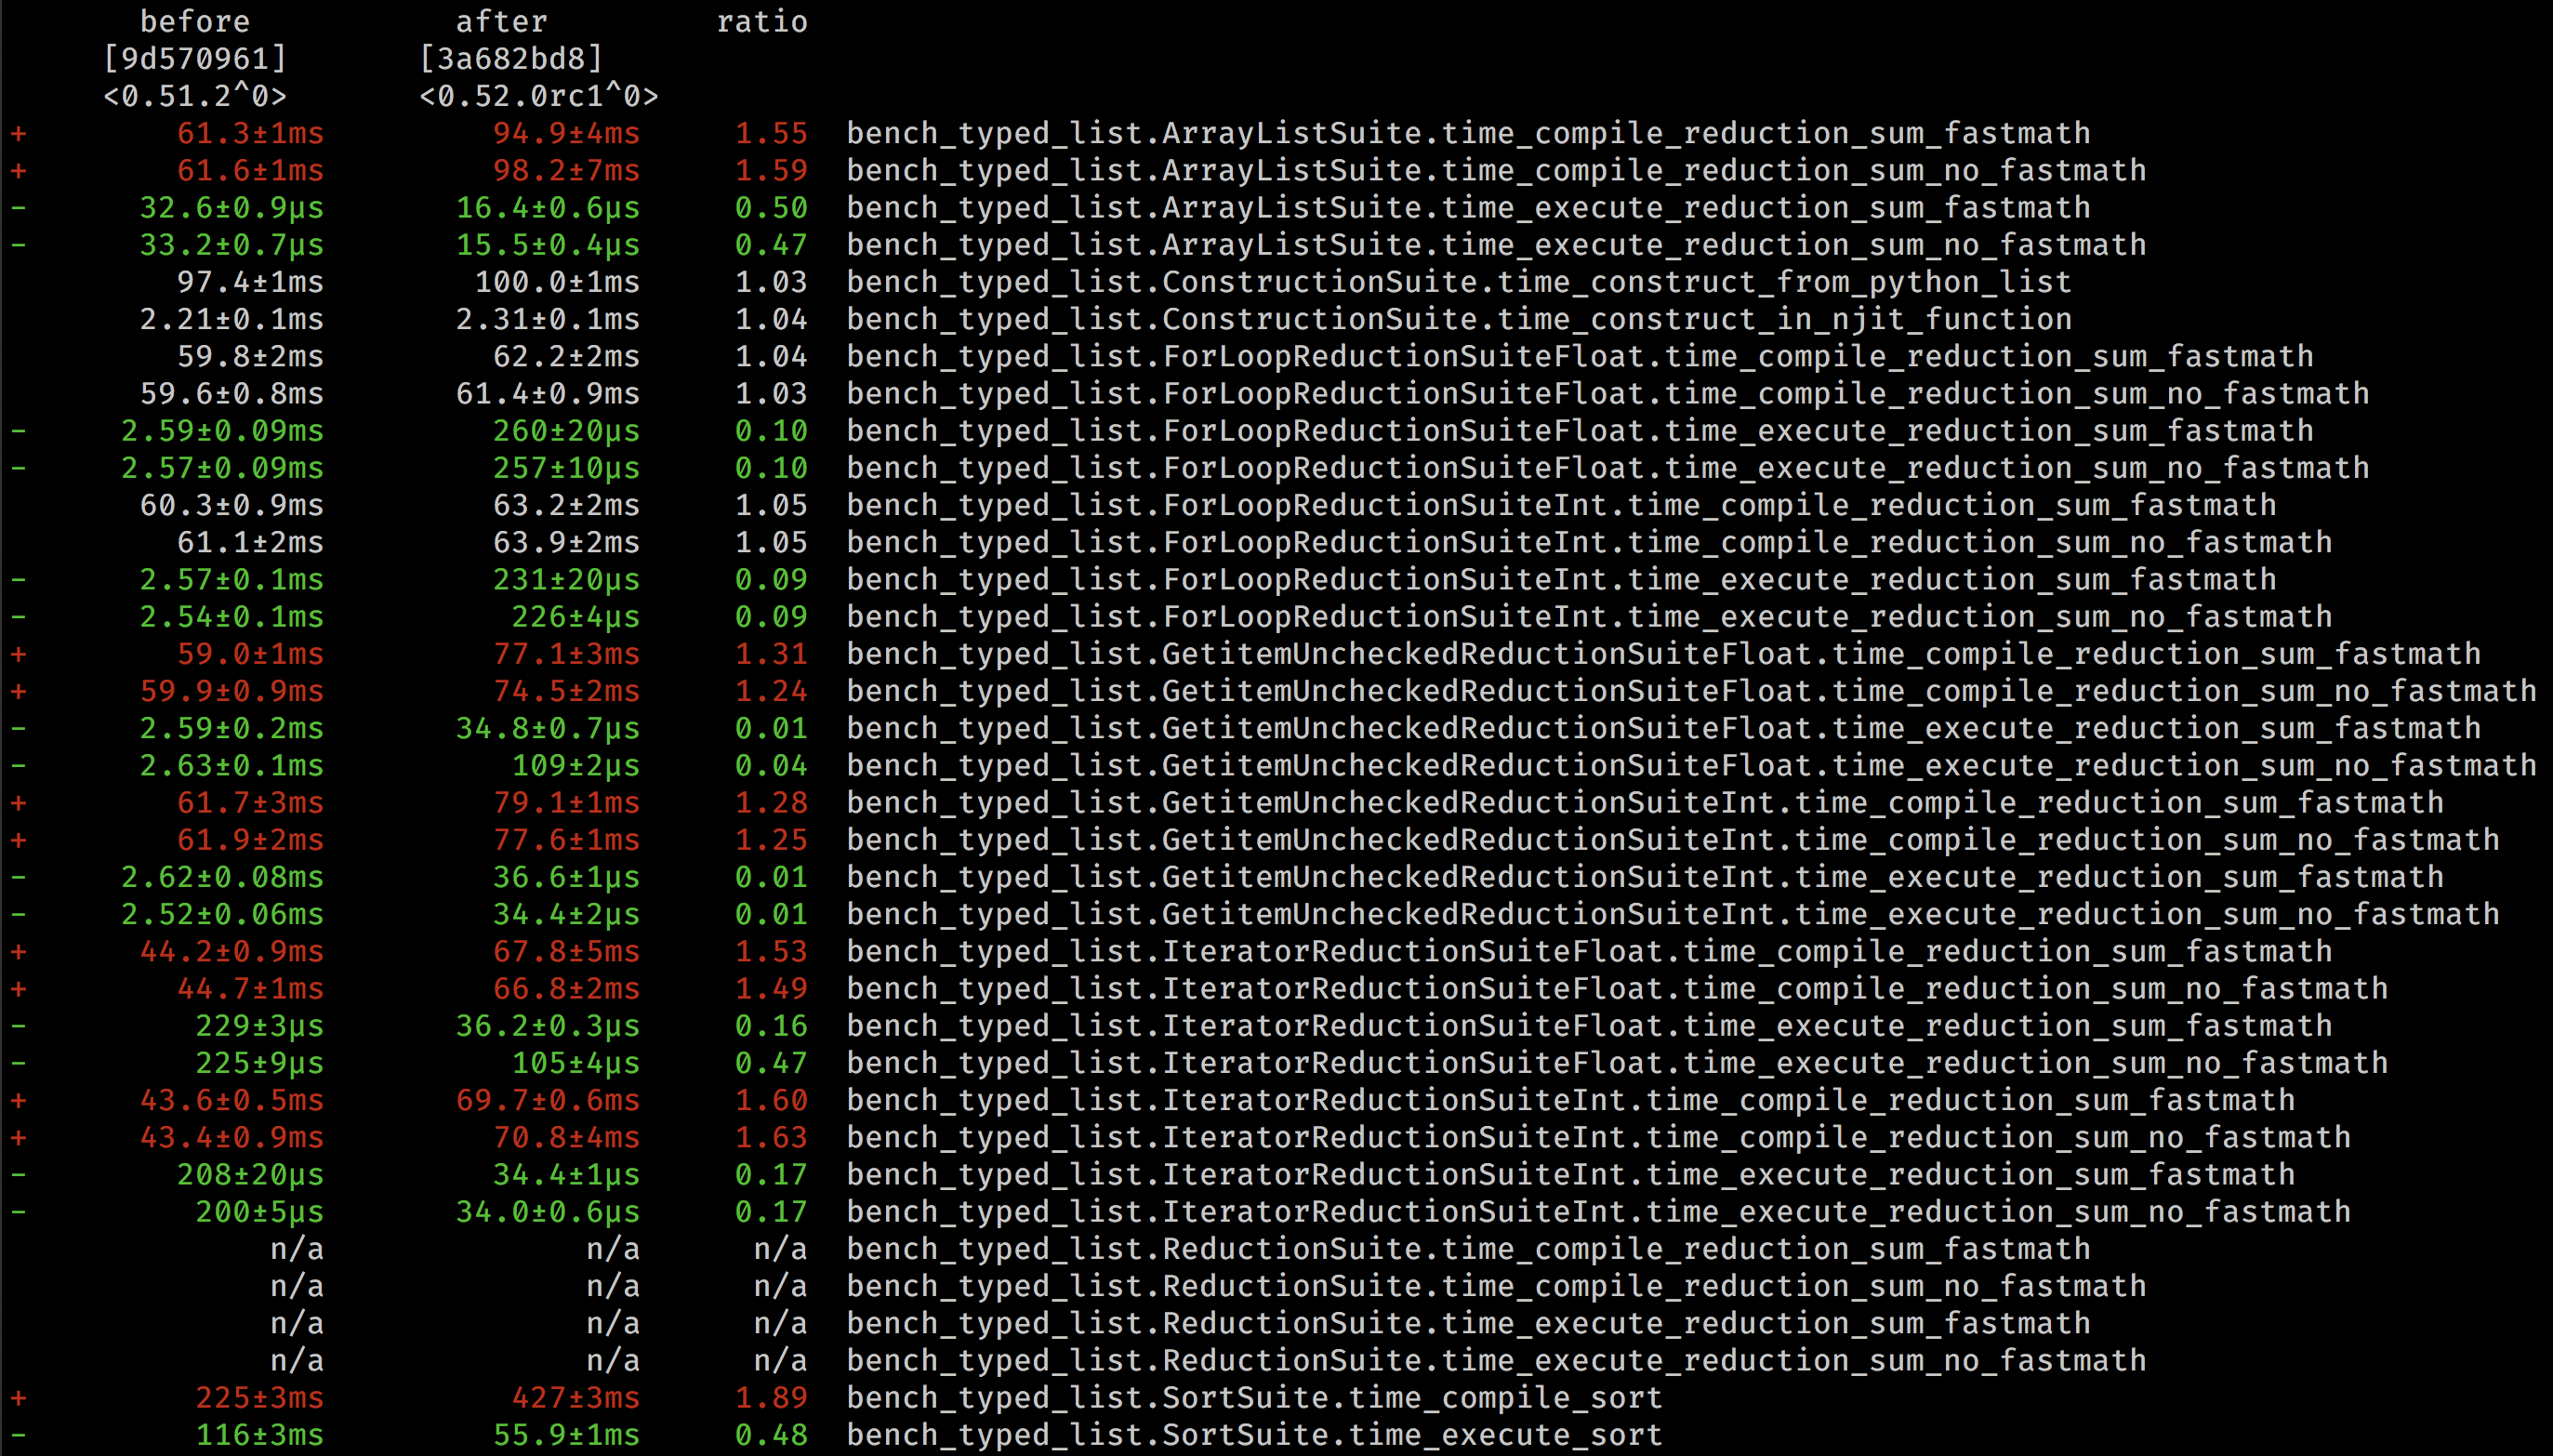

In [3]:
Image("asv_compare02.png")

# Execution Times

In [4]:
execution = dfc1.filter(regex='.*execute.*', axis=0).filter(regex="^((?!sort).)*$", axis=0)

In [5]:
plot02(execution, width=1000)

:Bars   [index,Variable]   (value)

# Compilation Times

In [6]:
compile_ = dfc1.filter(regex='.*compile.*', axis=0).filter(regex="^((?!sort).)*$", axis=0)

In [7]:
plot02(compile_)

:Bars   [index,Variable]   (value)

# Sort use-case

In [8]:
plot02(dfc1.filter(regex='.*sort.*', axis=0), height=150)

:Bars   [index,Variable]   (value)

# The impact of the new C++ refpruner

The last thing to look at is the impact of the new refpruner, and where it has impact, specifically.

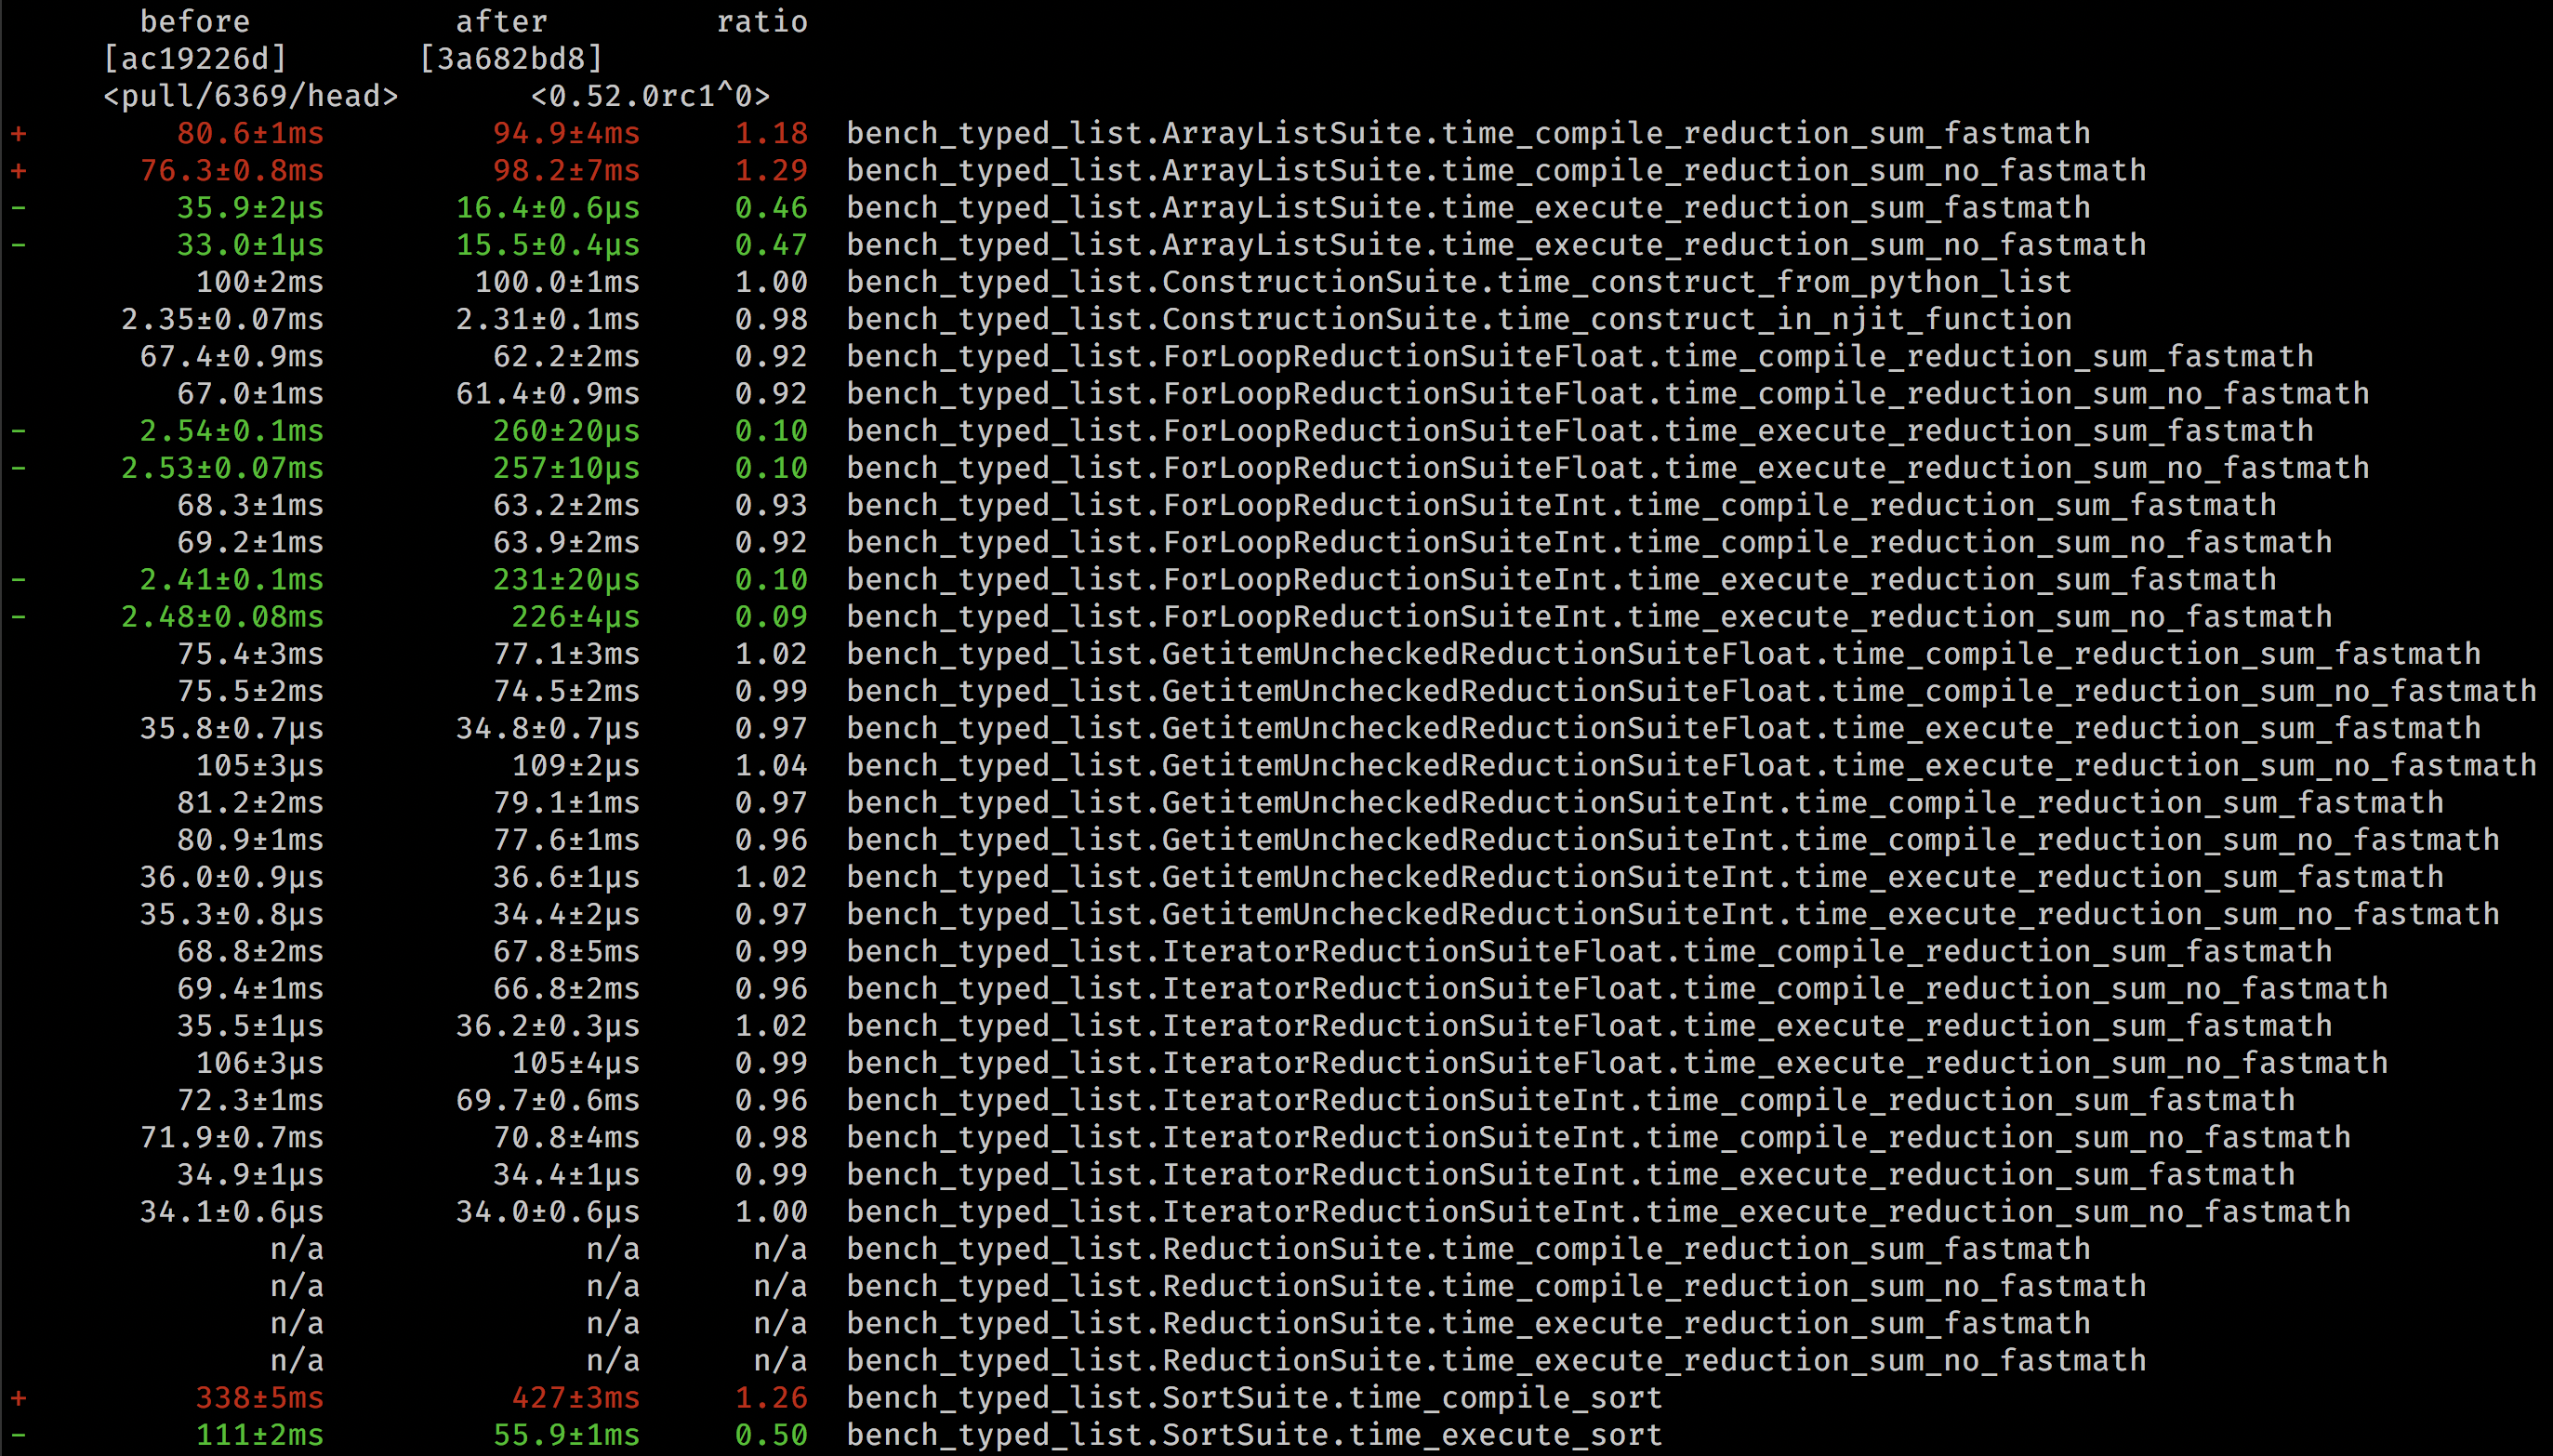

In [9]:
Image("asv_compare03.png")

In [10]:
plot02(dfc2.filter(regex='.*execute.*', axis=0).filter(regex="^((?!sort).)*$", axis=0), height=1000)

:Bars   [index,Variable]   (value)

In [11]:
plot02(dfc2.filter(regex='.*compile.*', axis=0).filter(regex="^((?!sort).)*$", axis=0), height=1000)

:Bars   [index,Variable]   (value)

In [12]:
plot02(dfc2.filter(regex='.*sort.*', axis=0), height=150)

:Bars   [index,Variable]   (value)